In [312]:
import pyFAI, pyFAI.azimuthalIntegrator, fabio
import numpy as np
from pyFAI.gui import jupyter
import glob, os, re
import matplotlib.pyplot as plt

Give the path to the files.

Notes on creating the calibration are found on the [LightForm Wiki](https://lightform-group.github.io/wiki/tutorials/sxrd-caking-dioptas)

[TODO] Setup calibration using pyFAI

In [27]:
# Path to calibration image
calibration_image = '/Users/mbcx9cd4/Documents/GitHub/pyFAI-integration-caking/calibration/DLS_CeO2_1200mm.tif'

# Path to calibration .poni file
calibration_file = '/Users/mbcx9cd4/Documents/GitHub/pyFAI-integration-caking/calibration/DLS_CeO2_1200mm.poni'

# Path to dark image
dark_image = '/Users/mbcx9cd4/Documents/GitHub/pyFAI-integration-caking/data/dark_pixium_03150.tif'

# Path to raw data image
pattern_image = '/Users/mbcx9cd4/Documents/GitHub/pyFAI-integration-caking/data/pixium_03150.tif'

We can write image data to an array using [FabIO](https://pythonhosted.org/fabio/getting_started.html).

image: <fabio.tifimage.TifImage object at 0x7f85bd3c34a8>
image_array: <class 'numpy.ndarray'> (1441, 1440) uint32
image_array: <class 'numpy.ndarray'> (1441, 1440) uint32


<AxesSubplot:>

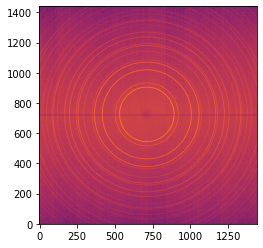

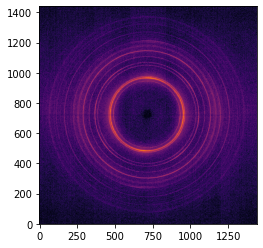

In [95]:
# write the calibration file to an image array
image = fabio.open(calibration_image)
print("image:", image)

calibration_image_array = image.data
print("image_array:", type(image_array), image_array.shape, image_array.dtype)

jupyter.display(calibration_image_array)

# write the pattern file to an image array
image = fabio.open(pattern_image)

pattern_image_array = image.data
print("image_array:", type(image_array), image_array.shape, image_array.dtype)

jupyter.display(pattern_image_array)

Because the data is in arrays, we can do things like subtract the image. This could be useful for subtracting a dark image of the detector, for example.

<AxesSubplot:>

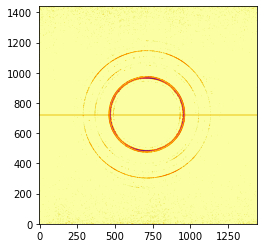

In [301]:
example_subtraction = pattern_image_array - calibration_image_array
jupyter.display(example_subtraction)

First, we need to load the calibration, which contains information about our beamline setup, which we will use to perform an azimuthal integration or caking to the rest of our as-yet 'uncalibrated' data. To load an `azimuthal integrator` object or `ai` we use [pyFAI](https://pyfai.readthedocs.io/en/latest/).

In [41]:
ai = pyFAI.load(calibration_file)
print("\nIntegrator: \n", ai)


Integrator: 
 Detector Detector	 Spline= None	 PixelSize= 2.960e-04, 2.960e-04 m
Wavelength= 1.393000e-11m
SampleDetDist= 1.194046e+00m	PONI= 2.114663e-01, 2.067728e-01m	rot1=-0.003366  rot2= 0.000439  rot3= 0.000000 rad
DirectBeamDist= 1194.053mm	Center: x=712.136, y=716.184 pix	Tilt=0.195 deg  tiltPlanRotation= 7.430 deg


To perform an azimuthal integration we use `ai.integrate1d`. 

There is also an `integrate2d` function, which is designed for caking of the data.

[TODO] - review all available options and determine those needed for our Diamond and DESY data.

In [85]:
help(ai.integrate1d)

Help on method _integrate1d_legacy in module pyFAI.azimuthalIntegrator:

_integrate1d_legacy(data, npt, filename=None, correctSolidAngle=True, variance=None, error_model=None, radial_range=None, azimuth_range=None, mask=None, dummy=None, delta_dummy=None, polarization_factor=None, dark=None, flat=None, method='csr', unit=q_nm^-1, safe=True, normalization_factor=1.0, block_size=32, profile=False, all=False, metadata=None) method of pyFAI.azimuthalIntegrator.AzimuthalIntegrator instance
    Calculate the azimuthal integrated Saxs curve in q(nm^-1) by default
    
    Multi algorithm implementation (tries to be bullet proof), suitable for SAXS, WAXS, ... and much more
    
    
    
    :param data: 2D array from the Detector/CCD camera
    :type data: ndarray
    :param npt: number of points in the output pattern
    :type npt: int
    :param filename: output filename in 2/3 column ascii format
    :type filename: str
    :param correctSolidAngle: correct for solid angle of each pixel if

An azimuthal integration can be performed like this.

*Note, the number of points in 2-theta is defined by the user. The azimuthal range runs from -180 to 180, or -pi to pi, rather than 0 to 360. An output .dat file can be saved, which contains a header of metadata. A numpy array of 2-theta and intensity is returned as result.*

In [307]:
result = ai.integrate1d(pattern_image_array,
                        npt=10000,
                        azimuth_range=(-180,180),
                        unit="2th_deg",
                        correctSolidAngle=True,
                        polarization_factor=0.99,
                        method='full_csr',
                        filename="/Users/mbcx9cd4/Documents/GitHub/pyFAI-integration-caking/analysis/integrated.dat")

print('Size of result numpy array =', np.shape(result))

Size of result numpy array = (2, 10000)


We could also create a loop to save our data for the cakes in .dat file format using `ai.integrate1d`. 

But, this is slow.

In [173]:
number_of_cakes = 10

step = 360/number_of_cakes

data=[]

for number in range(0,number_of_cakes):
    azimuth_low = -180 + step*number
    azimuth_high = azimuth_low + step
    print(azimuth_low)
    result = ai.integrate1d(pattern_image_array,
                            npt=1000,
                            azimuth_range=(azimuth_low,azimuth_high),
                            unit="2th_deg",
                            correctSolidAngle=True,
                            polarization_factor=0.99,
                            method='full_csr')
    data.append(result) 
print(np.shape(data))

-180.0
-144.0
-108.0
-72.0
-36.0
0.0
36.0
72.0
108.0
144.0
(10, 2, 1000)


Instead, we could obtain the results of caked slices using `ai.integrate2d` (as shown [here](https://pyfai.readthedocs.io/en/latest/usage/tutorial/Introduction/introduction.html) and [here](https://pyfai.readthedocs.io/en/latest/usage/cookbook/integration_with_python.html)). This is much faster. The data can be saved as a '.edf' file and a class of the caked results is also returned.

[TODO] - Not sure how to get a cake that covers different angles, such as 175 to -175 for example.

In [304]:
result = ai.integrate2d(pattern_image_array,
                        1000,
                        36,
                        unit="2th_deg",
                        correctSolidAngle=True,
                        polarization_factor=0.99,
                        method='full_csr',
                        filename = "/Users/mbcx9cd4/Documents/GitHub/pyFAI-integration-caking/analysis/integrated.edf")
print('The result is a class of 3 arrays, with shape: ', np.shape(result))
print('The 1st array contains the integrated intensity for each cake, with shape: ', np.shape(result[0]))
print('The 2nd array contains the two-theta values, with shape: ', np.shape(result[1]))
print('The 3rd array contains the angle of the cakes, with shape: ', np.shape(result[2]))

The result is a class of 3 arrays, with shape:  (3,)
The 1st array contains the integrated intensity for each cake, with shape:  (36, 1000)
The 2nd array contains the two-theta values, with shape:  (1000,)
The 3rd array contains the angle of the cakes, with shape:  (36,)


We can view the contents of this '.edf' file using FabIO.

In [305]:
cake = fabio.open("/Users/mbcx9cd4/Documents/GitHub/pyFAI-integration-caking/analysis/integrated.edf")
print(cake.header)
print("cake:", type(cake.data), cake.data.shape, cake.data.dtype)

{
  "EDF_DataBlockID": "0.Image.Psd",
  "EDF_BinarySize": "144000",
  "EDF_HeaderSize": "1536",
  "ByteOrder": "LowByteFirst",
  "DataType": "FloatValue",
  "Dim_1": "1000",
  "Dim_2": "36",
  "Image": "0",
  "HeaderID": "EH:000000:000000:000000",
  "Size": "144000",
  "Engine": "Detector Detector Spline= None PixelSize= 2.960e-04, 2.960e-04 m Wavelength= 1.393000e-11m SampleDetDist= 1.194046e+00m PONI= 2.114663e-01, 2.067728e-01m rot1=-0.003366 rot2= 0.000439 rot3= 0.000000 rad DirectBeamDist= 1194.053mm Center: x=712.136, y=716.184 pix Tilt=0.195 deg tiltPlanRotation= 7.430 deg",
  "detector": "Detector",
  "pixel1": "0.000296",
  "pixel2": "0.000296",
  "max_shape": "None",
  "dist": "1.1940462449808116",
  "poni1": "0.2114663341307606",
  "poni2": "0.2067728488004498",
  "rot1": "-0.0033662037083792896",
  "rot2": "0.00043898240282549706",
  "rot3": "4.959128260023292e-10",
  "wavelength": "1.393e-11",
  "2th_deg_min": "0.01038829058979857",
  "2th_deg_max": "14.269516795639806",
 

To iterate through some images we can create a loop, create an array for the data and then save it as a text file.

This caked dataset is now saved in a format that we can use in [xrdfit](https://xrdfit.readthedocs.io/en/stable/) to analyse how the single peak profiles change over time.

In [316]:
# user inputs
number_of_points = 10000
number_of_cakes = 36

# get a list of the files
image_list = sorted(glob.glob("/Users/mbcx9cd4/Documents/GitHub/pyFAI-integration-caking/data/pixium*"))

for image_path in image_list:
    # create empty array
    caked_data = np.zeros(shape=(number_of_cakes+1, number_of_points))
    
    # create an image array and cake the data
    image = fabio.open(image_path)
    pattern_image_array = image.data
    result = ai.integrate2d(pattern_image_array,
                            number_of_points,
                            number_of_cakes,
                            unit="2th_deg",
                            correctSolidAngle=True,
                            polarization_factor=0.99,
                            method='full_csr')  
    
    # write the caked result to the array
    for number in range(0,number_of_cakes):
        if number == 0:
            caked_data[0] = result[1]
            caked_data[1] = result[0][0]
        else:   
            caked_data[number+1] = result[0][number]
            
    # swop the rows/columns
    caked_data.transpose()
    
    # get the tiff number from the filename
    regex = re.compile(r'\d+')
    path_numbers = [int(x) for x in regex.findall(image_path)]
    tiff_number = path_numbers[2]
    
    # write out the caked data to a text file
    output_path = f"/Users/mbcx9cd4/Documents/GitHub/pyFAI-integration-caking/analysis/pixium_{tiff_number:05}.dat"
    np.savetxt(output_path, caked_data)

(3.0, 4.0)

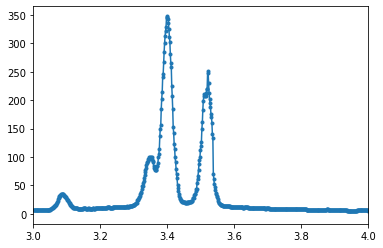

In [328]:
plt.plot(caked_data[0],caked_data[2], marker = ".")
plt.xlim(3,4)